In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l2
from keras.layers import BatchNormalization
from math import sqrt
from matplotlib import pyplot
from numpy import split
from numpy import array
from numpy.random import seed
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
from sklearn.decomposition import PCA
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf

Using TensorFlow backend.


## Data Preprocessing

In [2]:
# Interpolate the middle point use stochastic interpolation built by last group
def interpolate_gaussian(data, num_between, var=8):  # Data should be univariate time series in pd dataframe

    new_dat = np.zeros(1)

    for i in range(len(data)):
        new_dat = np.append(new_dat, data.iloc[i, :].values[0])
        if (i != (len(data) - 1)):
            step = (data.iloc[i + 1, :].values[0] - data.iloc[i, :].values[0]) / (num_between + 1)
            for j in range(num_between):
                k = data.iloc[i, :].values[0] + j * step + np.random.normal(loc=0.0,
                                                                            scale=1 / (var * (num_between + 1)))
                new_dat = np.append(new_dat, k)
    interpolated_data = pd.DataFrame(new_dat)
    interpolated_data = interpolated_data.iloc[1:len(interpolated_data), :]

    return (interpolated_data)


def prep_dat(d, n_step=270, n_ahead=360):  # Train a network for every step ahead (4 quarters, 8 quarters)
    # Prepare data for input/output of NNs, n_step is number of historical time steps (days) to include in regression task
    # to predict next quarter cash flows, assuming 90 days in a quarter

    a = d.copy()

    for i in range(1, n_step):
        ind = "t+" + str(i)
        a[ind] = a.iloc[:, 0].shift(-i)  # Use n_step historical observations to predict next quarter

    a["Q_Next"] = a.iloc[:, 0].shift(-(n_step + n_ahead))  # Next quarter(s) prediction

    a.dropna(
        inplace=True)  # last (n_step + n_ahead) rows will be NANs since shifting forward for "Next Quarter" Variable

    return (a)

#get distribution
def get_main(files, sheet):
    d = pd.read_excel(files, sheet_name = sheet, header = 2, usecols = "A:G",index_col = 0)[['Distributed']]
    d.dropna()
    delta = data_process(d)
    delta = delta.rename(columns = {0:sheet})
    return delta

def Pca(data,num_com):
    testy = data["All"]
    testx = data.iloc[:,1:]
    pca = PCA(n_components=num_com)
    fit = pca.fit_transform(testx)
    ratio = pca.fit(testx)
    print(f"total explained variance for {num_com} components is",sum(ratio.explained_variance_ratio_))
    dataset2 = pd.concat([testy.reset_index().drop(columns = 'index'),pd.DataFrame(fit)],axis = 1)
    return dataset2


def data_process(data):

    log_data = np.log(data).diff().dropna()
    _train = interpolate_gaussian(log_data.iloc[0:math.floor(0.7*len(log_data))],in_between,6)
    _test = interpolate_gaussian(log_data.iloc[math.floor(0.7*len(log_data)):len(log_data)],in_between,8)
    result = pd.concat([_train, _test])
    return result 

def get_macro(files, sheet):
    d = pd.read_excel(files, sheet_name = sheet, header = 2, usecols = "A:G",index_col = 0)[["Called Up"]]
    d = d.dropna()
    delta = data_process(d)
    delta = delta.rename(columns = {0:sheet})
    return delta

# take pd dataframe into processable numpy array
def trans_dat(data):
    pre_col = 0
    for col in data.columns:
        if pre_col == 0:
            sup_dat = prep_dat(data[[col]]).drop(columns='Q_Next').values
            sup_dat = np.expand_dims(sup_dat,axis=2)
            pre_col = col
        else:
            
            sup_dat1 = prep_dat(data[[col]]).drop(columns='Q_Next').values
            sup_dat1 = np.expand_dims(sup_dat1,axis=2)
            sup_dat = np.concatenate((sup_dat,sup_dat1),axis=2)            
            
    return sup_dat

def split_dataset_x(data):
    # split into standard weeks
    num_features = data.shape[2]
    train =  data[0:math.floor(0.7 * len(data)),0:hidden_size,0:num_features]
    test = data[math.floor(0.7 * len(data)):-1,0:hidden_size,0:num_features]
#     # restructure into windows of weekly data
#     train = array(split(train, int(len(train)/7)))
#     test = array(split(test, int(len(test)/7)))
    return train, test
# 1176/7 = 168, 546/7 = 78
def split_dataset_y(data):
    train = np.expand_dims(data[0:math.floor(0.7 * len(data))],axis = 1)
    test = np.expand_dims(data[math.floor(0.7 * len(data)):-1],axis = 1)
    return train,test


def evaluation_model(model,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    history = model.history
    

    y_hat_train = model.predict(X_train,verbose = 0)
    y_hat_test = model.predict(X_test,verbose = 0)
    
    train_mse = mean_squared_error(y_hat_train[:,0],y_train)
    test_mse = mean_squared_error(y_hat_test[:,0],y_test)
    
    print("Train set MSE is",train_mse)
    print("Test set MSE is",test_mse)
    
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'],label = 'training loss')
#     plt.plot(history.history['val_loss'],label = 'validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Training loss')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_train[:,0],label = 'prediction')
    plt.plot(y_train,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.title('Train set actual/predict')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_test[:,0],label = 'prediction')
    plt.plot(y_test,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.suptitle('Test set actual/predict')
    plt.legend()

def evaluation_model_conv(model,X_train,X_test,y_train=y_train,y_test=y_test,n_steps=3,n_length=90):
    import matplotlib.pyplot as plt
    %matplotlib inline
    history = model.history
    
    n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
    X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))
    y_hat_train = model.predict(X_train,verbose = 0)
    y_hat_test = model.predict(X_test,verbose = 0)
    
    train_mse = mean_squared_error(y_hat_train[:,0],y_train)
    test_mse = mean_squared_error(y_hat_test[:,0],y_test)
    
    print("Train set MSE is",train_mse)
    print("Test set MSE is",test_mse)
    
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'],label = 'training loss')
#     plt.plot(history.history['val_loss'],label = 'validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Training loss')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_train[:,0],label = 'prediction')
    plt.plot(y_train,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.title('Train set actual/predict')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_test[:,0],label = 'prediction')
    plt.plot(y_test,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.suptitle('Test set actual/predict')
    plt.legend()



filename = "Buyout_Funds_Stats_2014.xlsx"
metric = 'Called Up'
in_between = 90
#The time used to predict the future, equal to n_step in prep_dat
hidden_size = 270

In [3]:

def build_model(train_x,train_y,n_input):

    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add((Dense(200, activation='relu')))
    model.add((Dense(n_outputs)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.01)
    return model

def build_model_encoder(train_x,train_y,n_input):
    # prepare data

    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add((Dense(200,activation='relu')))
    model.add(TimeDistributed(Dense(100, activation='relu')))
#     model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.01)
    return model



def build_model_conv(train_x,train_y,n_input):

    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.01)
    return model

def build_model_conv2(train_x,train_y,n_input):
    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # define model

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    
#     model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
#     model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.01)
    return model

In [6]:
#main data
filename = "VC_Funds_Stats_2014.xlsx"
dat_all = get_macro(filename, "All")

filename = "Copy of Buyout_Funds_Stats_2014.xlsx"
#macro factors
dat_ISMmanu = get_macro(filename, "ISMmanu")
dat_GDP = get_macro(filename, "GDP")
dat_unemployment = get_macro(filename, "unemployment")
ppi = get_macro(filename,"PPI")
ISMnonmanu = get_macro(filename,"ISMnon-manu")
nfp = get_macro(filename,"NFP")
ppi_m = get_macro(filename,"core PPI m_m")
ppi_y = get_macro(filename,"core PPI year")
retail = get_macro(filename,"retail index")
core_retail = get_macro(filename,"core retail index")
consumer_m = get_macro(filename,"consumer product index m_m")
cpi_m = get_macro(filename,"core CPI m_m")
cpi_y = get_macro(filename,"core CPI year")
new_house = get_macro(filename,"New Housing")
consumer_sentiment = get_macro(filename,"Michigan Consumer Sentiment Ind")
sale_house = get_macro(filename,"House sales")
dgo = get_macro(filename,"Durable Goods Orders m_m")
dgo_et = get_macro(filename,"DGO m_m exclude transportation")
CCI = get_macro(filename,"Conference Board's CCI")
ir = get_macro(filename,"interest rate")

dataset3  = pd.concat([dat_all, dat_unemployment, dat_ISMmanu, dat_GDP, ppi,
                     ISMnonmanu, nfp, ppi_m, ppi_y, retail, core_retail, consumer_m,
                       cpi_y, new_house, consumer_sentiment, 
                      sale_house, dgo, dgo_et, CCI, ir
                    ],axis = 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


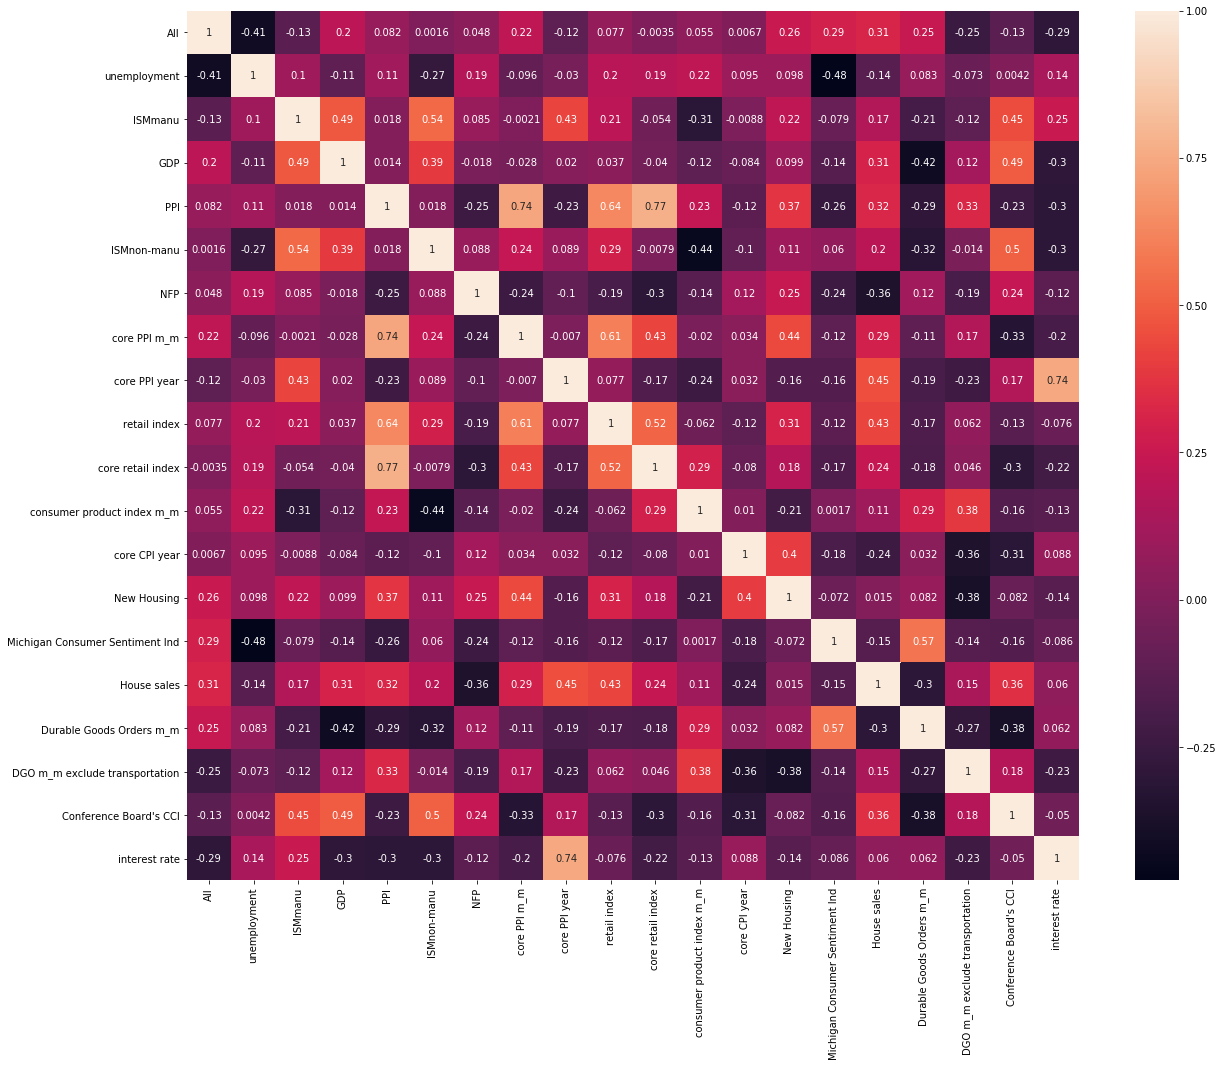

In [7]:
plt.figure(figsize = (20,16))
sn.heatmap(dataset3.corr(),annot=True)

## Traditional LSTM model

## Univaraite Input

In [18]:
dataset = dat_all
X = trans_dat(dataset)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

Train set MSE is 0.00242864089637308
Test set MSE is 0.0011251215212489155


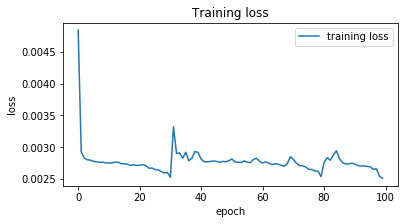

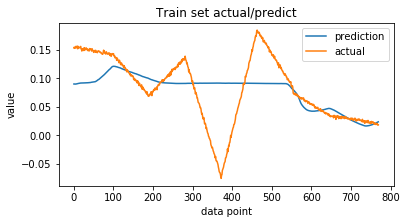

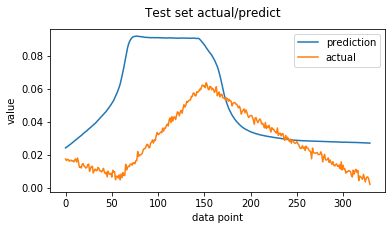

In [19]:
model_uni_lstm = build_model(X_train,y_train,270)
evaluation_model(model_uni_lstm)

## All macro

In [10]:
dataset3  = pd.concat([dat_all, dat_unemployment, dat_ISMmanu, dat_GDP, ppi,
                     ISMnonmanu, nfp, ppi_m, ppi_y, retail, core_retail, consumer_m,
                       cpi_y, new_house, consumer_sentiment, 
                      sale_house, dgo, dgo_et, CCI, ir
                    ],axis = 1)

In [11]:
X = trans_dat(dataset3)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

Train set MSE is 3.783381623114348e-06
Test set MSE is 0.001189963432621182


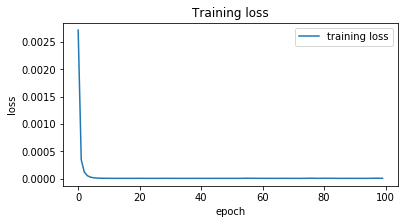

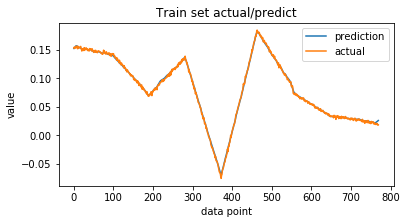

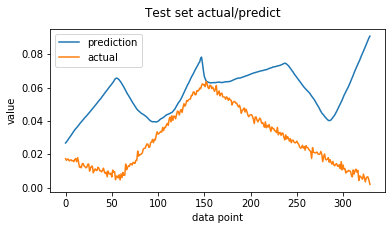

In [12]:
model_all_lstm = build_model(X_train,y_train,270)
evaluation_model(model_all_lstm)

## PCA features

In [13]:
X = trans_dat(Pca(dataset3,9))
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

total explained variance for 9 components is 0.991742801914878


Train set MSE is 4.531771853487727e-06
Test set MSE is 0.0007127502499383113


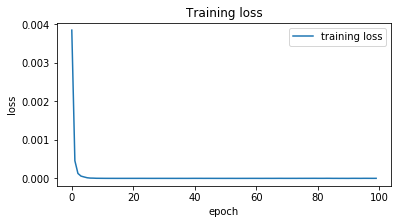

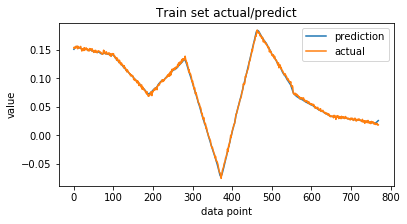

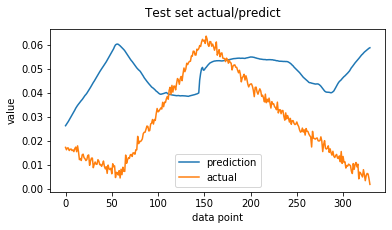

In [14]:
model_pca_lstm = build_model_encoder(X_train,y_train,270)
evaluation_model(model_pca_lstm)

## Encoder -decoder LSTM Univariate input

In [45]:
dataset = dat_all
X = trans_dat(dataset)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [46]:
model_uni_encoder = build_model_encoder(X_train,y_train,270)

Train set MSE is 2.2558564342148055e-05
Test set MSE is 0.0007105117416587866


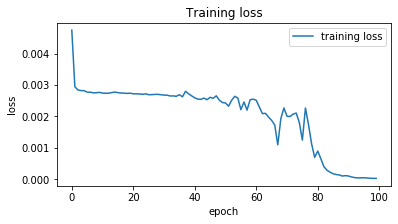

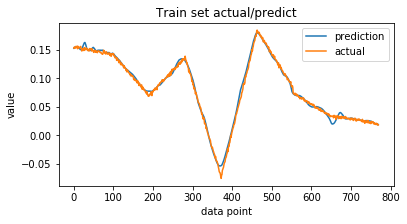

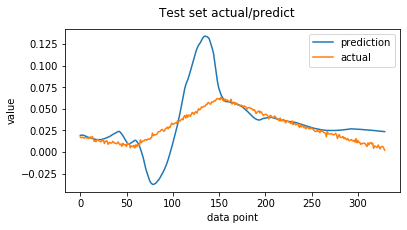

In [47]:
evaluation_model(model_uni_encoder)

## 19 Macro factors with LSTM & encoder-decoder LSTM

In [20]:
dataset3  = pd.concat([dat_all, dat_unemployment, dat_ISMmanu, dat_GDP, ppi,
                     ISMnonmanu, nfp, ppi_m, ppi_y, retail, core_retail, consumer_m,
                       cpi_y, new_house, consumer_sentiment, 
                      sale_house, dgo, dgo_et, CCI, ir
                    ],axis = 1)

In [21]:
X = trans_dat(dataset3)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [22]:
model_all_encoder = build_model_encoder(X_train,y_train,270)

Train set MSE is 3.0357990846902254e-06
Test set MSE is 0.0012467722024268053


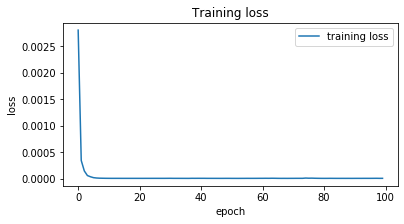

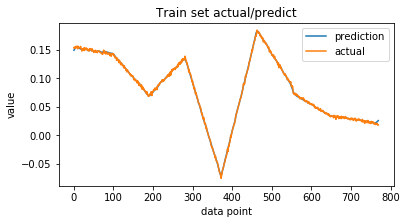

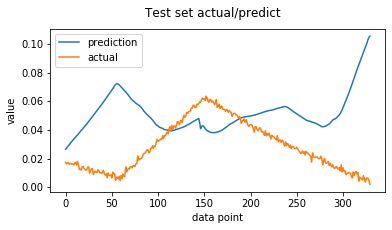

In [23]:
evaluation_model(model_all_encoder)

##  feature selection on the macro factors using PCA

In [24]:
X = trans_dat(Pca(dataset3,9))
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

total explained variance for 9 components is 0.9917428019148762


In [25]:
model_pca_encoder = build_model_encoder(X_train,y_train,270)

Train set MSE is 4.981166732821954e-06
Test set MSE is 0.0012064668374373471


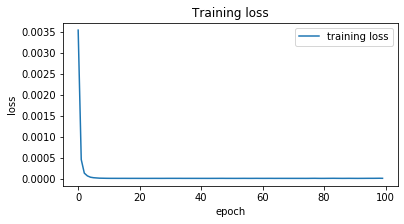

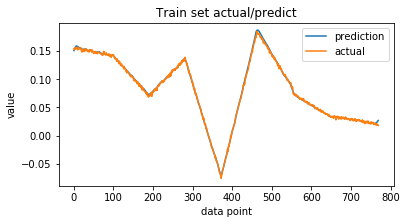

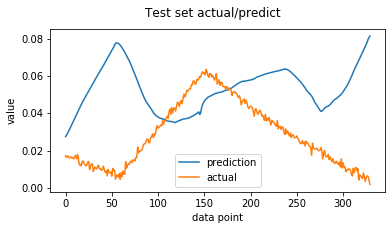

In [26]:
evaluation_model(model_pca_encoder)

## CNN encoder-decoder LSTM univariate

In [27]:
dataset = dat_all
X = trans_dat(dataset)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [28]:
model_uni_cnn = build_model_conv(X_train,y_train,270)

Train set MSE is 1.1960764657986165e-05
Test set MSE is 0.004908687091169263


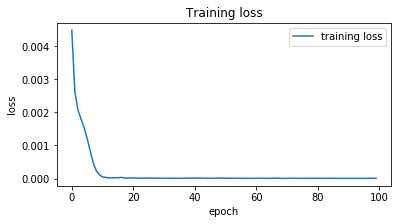

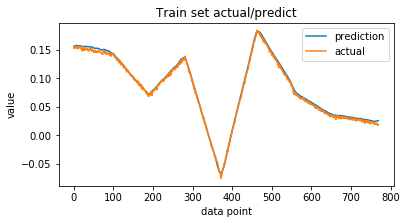

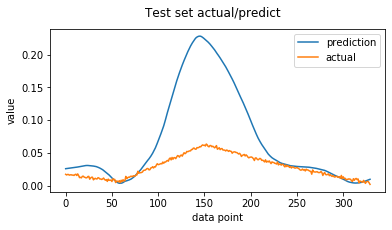

In [29]:
evaluation_model(model_uni_cnn)

## CNN encoder-decoder LSTM multivariate

In [30]:
X = trans_dat(dataset3)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

Train set MSE is 2.779537999607492e-06
Test set MSE is 0.0006654913606920099


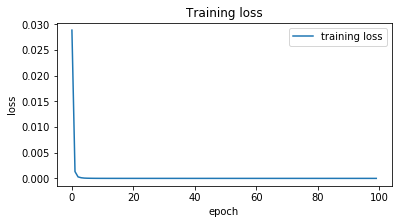

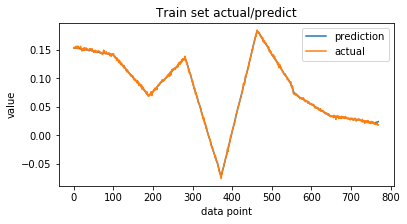

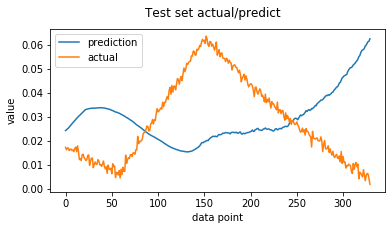

In [31]:
model_all_cnn = build_model_conv(X_train,y_train,270)
evaluation_model(model_all_cnn)

## CNN Encoder-decoder LSTM with PCA selected variables

In [32]:
X = trans_dat(Pca(dataset3,9))
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

total explained variance for 9 components is 0.9917428019148778


Train set MSE is 3.2687673613994777e-06
Test set MSE is 0.0007700962210716858


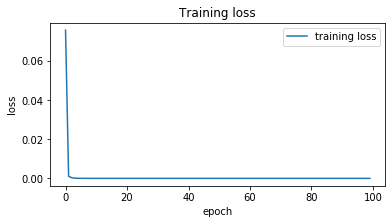

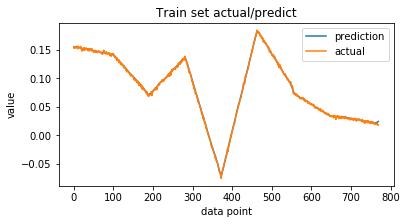

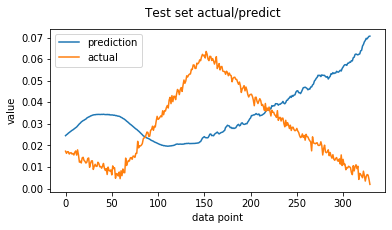

In [33]:
model_pca_cnn = build_model_conv(X_train,y_train,270)
evaluation_model(model_pca_cnn)

## Conv 2-d

Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN-LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves.

In [34]:
#The time used to predict the future, equal to n_step in prep_dat
hidden_size = 270
n_steps, n_length = 3,90   

## Univariate

In [35]:
dataset = dat_all
X = trans_dat(dataset)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

Train set MSE is 3.775532829770266e-05
Test set MSE is 0.00014653712921160433


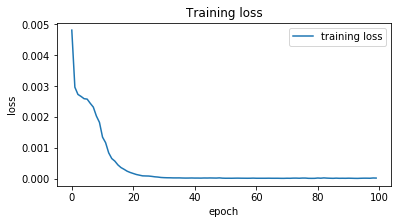

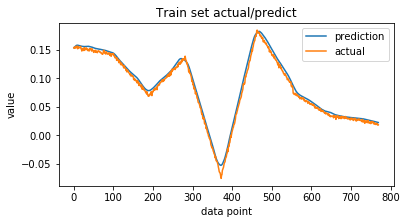

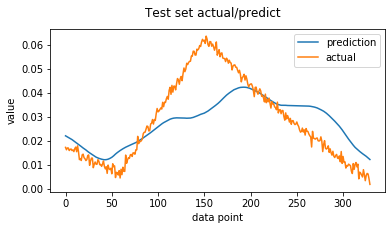

In [36]:
model_uni_con2 = build_model_conv2(X_train,y_train,270)
evaluation_model_conv(model_uni_con2,X_train,X_test)

## All macro

In [37]:
X = trans_dat(dataset3)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [38]:
model_all_con2 = build_model_conv2(X_train,y_train,270)

Train set MSE is 4.4709348825411295e-06
Test set MSE is 0.00029197641718038236


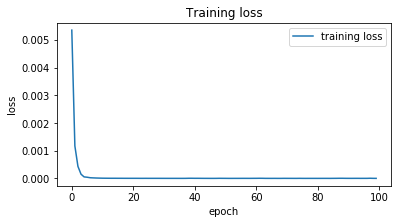

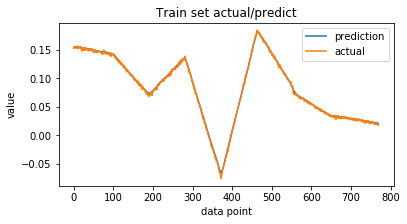

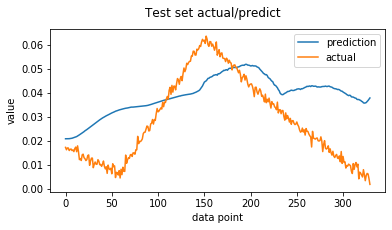

In [39]:
evaluation_model_conv(model_all_con2,X_train,X_test)

## PCA 

In [40]:
X = trans_dat(Pca(dataset3,9))
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

total explained variance for 9 components is 0.9917428019148763


Train set MSE is 6.302606849085836e-06
Test set MSE is 0.0005364992663839686


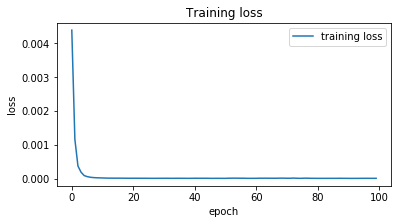

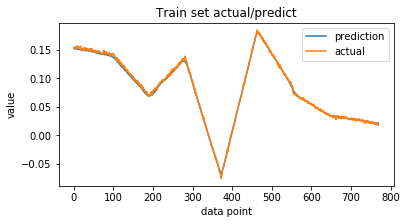

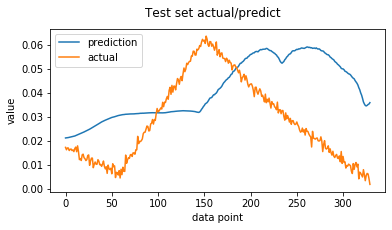

In [41]:
model_pca_con2 = build_model_conv2(X_train,y_train,270)
evaluation_model_conv(model_pca_con2,X_train,X_test)